# Magma ocean thermal evolution model
by Maxime Maurice (maxime.maurice@rice.edu)

### Dependencies and Packages

In [1]:
from physics import *
from classes import *
from chemistry import *
from redox import*
from petitRADTRANS import Radtrans
from climate import planets
from datapath import datapath

%matplotlib inline

Using MatPlotLib graphics


### case-specific settings

In [2]:
eq_C.coefs[O2]      = 0
eq_H.coefs[O2]      = 0
eq_CH.coefs[O2]     = 0
albedo              = 0.2
stellar_irradiation = 1./4*planets.Earth.L*(1.-albedo)*0.75
T_eq                = (1./4*planets.Earth.L*(1.-albedo)/phys.sigma)**(1./4)
T_pot               = 3003.# [K] corresponds to p_bot = 55GPa
T_surf              = 2800.# [K]
p_CMB               = 55e9 # [GPa] set pseudo-CMB at the pressure corresponding to 1000 km depth
BSE                 = pd.read_excel(datapath+'/BSE_composition.ods',index_col=0,sheet_name='molar').T['Palme and Oneill 2003']
BSE_mass            = 4e24 # [kg]

## Magma Ocean

In [3]:
MO = magma_ocean(T_pot, p_CMB, eos={'rho':'MK19','alpha':'N19','cp':'cst'}, g=planets.Earth.g, R=planets.Earth.a, N=100, fractional=True)

### melting curves

Text(0, 0.5, 'pressure [GPa]')

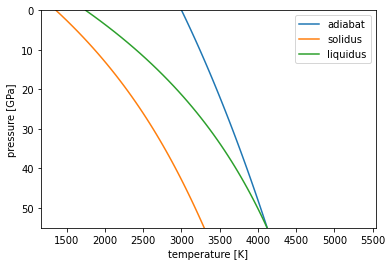

In [4]:
MO.setMeltingCurves(physics.mc['Earth'],0.)

# plot
plt.plot(MO.profiles['temperatures'],MO.profiles['pressures']*1e-9,label='adiabat')
MO.mc.plot()
plt.ylim(MO.p_bot*1e-9,0)
plt.legend()
plt.xlabel('temperature [K]')
plt.ylabel('pressure [GPa]')

### potential temperature

In [5]:
MO.updateT_pot(T_pot)

## Oxygen Fugacity

### ferrous- ferric-iron oxides
The partition coefficients are average values calculated for the crystallization sequence of the terrestrial MO from Elkins-Tanton 2008  
The initial Fe$^{3+}/\Sigma$Fe is calculated so that the $f_{O_2}$ at the core-mantle equilibration $p,T$ conditions is IW-2. In the present case, equilibration occurs at the bottom of the MO and $p_{\rm eq}=55$ GPa and $T_{\rm eq}$ is on the adiabat at  $p_{\rm eq}$.

#### Partition coefficients

In [6]:
Fe3plus.part_coef = 0.27
FeO.part_coef     = 0.94

In [7]:
part_coefs = {}
part_coefs['2000km'] = {}
part_coefs['2000km'][22e9]  = {'Fe3+':[0.7125,38.],   'H':[0.000495],'C':[0.0005]}
part_coefs['2000km'][18e9]  = {'Fe3+':[0.4365,2.5475],'H':[0.01515], 'C':[0.0005]}
part_coefs['2000km'][15e9]  = {'Fe3+':[0.3305,1.395], 'H':[0.00605], 'C':[0.001925]}
part_coefs['2000km'][2.5e9] = {'Fe3+':[0.149,0.173],  'H':[0.009],   'C':[0.00173]}
part_coefs['2000km'][1e9]   = {'Fe3+':[0.268,0.3175], 'H':[0.011],   'C':[0.002105]}
part_coefs['2000km'][0]     = {'Fe3+':[0.171,0.1965], 'H':[0.01],    'C':[0.00208]}

# Fe3+/FeT
def part_coefs_lookup(p,seq,elem,return_min=True):
    return_val = lambda x: min(x) if return_min else max(x)
    for p_ in part_coefs[seq]:
        if p<p_:
            continue
        else:
            return return_val(array2float(part_coefs[seq][p_][elem]))
def set_part_coef(var):
    Fe3plus.part_coef = part_coefs_lookup(var['p_bot'],'2000km','Fe3+')
    return Fe3plus.part_coef
MO.setParametrization('D_Fe3+_eff', set_part_coef,['p_bot'],is_profile=False)

#### Initial value

In [8]:
initial_ferric_to_ferrous_iron_oxide = ferric_to_ferrous_iron_H22(MO.p_bot, # pressure
                                                                  MO.adiabat.getT(MO.p_bot), # temperature
                                                                  10**(fO2_buffers_H22(MO.p_bot, MO.adiabat.getT(MO.p_bot))-2), # fO2
                                                                  BSE) # composition
initial_ferric_to_total_iron_ratio  = initial_ferric_to_ferrous_iron_oxide/(1+initial_ferric_to_ferrous_iron_oxide)
initial_ferrous_to_total_iron_ratio = 1.-initial_ferric_to_total_iron_ratio
MO.addSpecies([Fe3plus,FeO],[initial_ferric_to_total_iron_ratio*BSE['FeO']/100,initial_ferrous_to_total_iron_ratio*BSE['FeO']/100])
MO.to_frac=[Fe3plus,FeO]
MO.fractionation([Fe3plus,FeO])

### Set $f_{O_2}$ parametrization from Hirschmann 2022

In [9]:
MO.setParametrization('fO2',lambda var: fO2_sfc_H22(var['T_pot'],var['Fe3+_liquid']/(var['FeO_liquid']+var['Fe3+_liquid']),BSE),['T_pot','Fe3+_liquid','FeO_liquid'],is_profile=False)
#MO.setParametrization('fO2_sfc',lambda var: 10**(fO2_buffers_H22(1e5,var['T_pot'])-2),['T_pot'],is_profile=False)

### Redox equilibria

#### 2H$_2$+O$_2$=2H$_2$O

In [10]:
def K_H(variables):
    chemistry.eq_H.constant = equilibrium_constant_NATAF[eq_H.expression](variables['T_pot'])*variables['fO2']
    return chemistry.eq_H.constant
MO.setParametrization('K_H',K_H,['T_pot','fO2'],is_profile=False)

#### 2CO+O$_2$=2CO$_2$

In [11]:
def K_C(variables):
    chemistry.eq_C.constant = equilibrium_constant_NATAF[eq_C.expression](variables['T_pot'])*variables['fO2']
    return chemistry.eq_C.constant 
MO.setParametrization('K_C',K_C,['T_pot','fO2'],is_profile=False)

#### 2NH$_3$=N$_2$+3H$_2$

In [12]:
def K_N1(variables):
    chemistry.eq_N1.constant = equilibrium_constant_Zahnle20[eq_N1.expression](variables['T_pot'])
    return chemistry.eq_N1.constant 
MO.setParametrization('K_N1',K_N1,['T_pot'],is_profile=False)

#### CO+3H$_2$=CH$_4$+H$_2$O

In [13]:
def K_CH(variables):
    chemistry.eq_CH.constant = equilibrium_constant_Zahnle20[eq_CH.expression](variables['T_pot'])
    return chemistry.eq_CH.constant 
MO.setParametrization('K_CH',K_CH,['T_pot'],is_profile=False)

#### HCN+H$_2$O=CO$_2$+NH$_3$

In [14]:
def K_N2(variables):
    chemistry.eq_N2.constant = equilibrium_constant_Zahnle20[eq_N2.expression](variables['T_pot'])
    return chemistry.eq_N2.constant 
MO.setParametrization('K_N2',K_N2,['T_pot'],is_profile=False)

In [15]:
MO.to_spec=[H,C]

## Atmosphere

### Create atmosphere

In [16]:
MO.atm = atmosphere([],[],MO.adiabat.T_pot,pToA=10)
MO.addSpecies([H2,H2O,CO,CO2],[0.,EO_mass/BSE_mass,
                                          0.,0.5*EO_mass/BSE_mass*(H.atomic_mass*H2O.coefs[H]/H2O.molecular_mass)
                                                                 /(C.atomic_mass*CO2.coefs[C]/CO2.molecular_mass)],True)
#MO.addSpecies([H2,H2O,CO,CO2,CH4,NH3,N2,HCN],[0.,EO_mass/BSE_mass,
#                                          0.,0.5*EO_mass/BSE_mass*(H.atomic_mass*H2O.coefs[H]/H2O.molecular_mass)
#                                                                 /(C.atomic_mass*CO2.coefs[C]/CO2.molecular_mass),0.,
#                                          0.,2.8e-6,0.],True)

### Load reference composition

In [17]:
#MO.atm=multi_species_single_condensible_convective_atmosphere([H2,H2O,CO,CO2,CH4,NH3,N2,HCN],\
#         np.array([131002.,\
#                   131708.,\
#                   3039549.,\
#                   419206.,\
#                   0.1,\
#                   1.12,\
#                   117851.,\
#                   107.947]),\
#                  MO.atm.Ts,R=MO.R_out,g=MO.gravity,pToA=10,cond=H2O,T_str=200.)
MO.atm=multi_species_single_condensible_convective_atmosphere(np.array([H2,H2O,CO,CO2]),
                                                              np.array([136030.,131575.,3044050.,403901.]),
                                                              MO.atm.Ts,R=MO.R_out,g=MO.gravity,
                                                              pToA=10,cond=H2O,T_str=200.)
MO.atm.equilibria=[eq_H,eq_C]

### Calculate speciation

In [18]:
#O2.part_coef = 0.
#O2.alpha = 0.
#O2.beta = 0.
MO.speciation(MO.atm.equilibria,MO.to_spec)

### Evolve to desired composition

In [19]:
# Study parameters

H2O_EO_content      = 1
C_to_H              = 0.5

In [20]:
if H2O_EO_content > 1:
    H_system_ini = MO.content['system']['H']
    while MO.content['system']['H'] < H_system_ini * H2O_EO_content:
        MO.content['system']['H'] += 1e-6
        MO.speciation2(MO.atm.equilibria,MO.to_spec)
        
if C_to_H > 0.5 or H2O_EO_content > 1:
    while MO.content['system']['C']/MO.content['system']['H'] < C_to_H:
        MO.content['system']['C'] += 1e-6
        MO.speciation2(MO.atm.equilibria,MO.to_spec)

In [21]:
# Brouillon
#print('Parameters ================')
#print('Temperature =',MO.adiabat.T_pot,'K, Mass MO =',MO.M_system*1e3,'g, Mass Planet =',5.98e27,'g, Radius =', MO.R_out*1e-3,'km')
#print('Target ===================')
#print('logfO2-IW = ',np.log10(MO.averages['fO2_sfc'])-fO2_buffers_H22(MO.atm.ps,MO.adiabat.T_pot),',',
#      'H2O tot = ',MO.content['system']['H']/H2O.coefs[H]/H.atomic_mass*H2O.molecular_mass*1e6,'ppm,',
#      'C tot = ',MO.content['system']['C']*1e6,'ppm,',
#      'N tot = ',MO.content['system']['N']*1e6,'ppm,',
#      'Ar tot = ',0,'ppm',
#      'S tot = ',0,'ppm')
#print('Output ===================')
#print('Atmosphere')
#print('M am =',MO.atm.getMass(),'kg, '
#      'p_tot=',MO.atm.ps*1e-5,'bar, '
#      'N2 = ',MO.atm.partial_pressure['N2']/MO.atm.ps*N2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
#      'H2O= ',MO.atm.partial_pressure['H2O']/MO.atm.ps*H2O.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
#      'H2 = ',MO.atm.partial_pressure['H2']/MO.atm.ps*H2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
#      'CO2= ',MO.atm.partial_pressure['CO2']/MO.atm.ps*CO2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
#      'CO = ',MO.atm.partial_pressure['CO']/MO.atm.ps*CO.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
#      'CH4 = ',MO.atm.partial_pressure['CH4']/MO.atm.ps*CH4.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
#      'O2 = ',MO.averages['fO2_sfc']*1e5/MO.atm.ps*O2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
#      'HCN = ',MO.atm.partial_pressure['HCN']/MO.atm.ps*HCN.molecular_mass/MO.atm.average_molecular_mass*100,'wt%'
#      'NH3 = ',MO.atm.partial_pressure['NH3']/MO.atm.ps*NH3.molecular_mass/MO.atm.average_molecular_mass*100,'wt%')
#print('Silicate melt')
#print('H2O =',MO.content['liquid']['H2O']*1e6,'ppm, ',
#      'H2=',MO.content['liquid']['H2']*1e6,'ppm, ',
#      'CO2=',MO.content['liquid']['CO2']*1e6,'ppm, ',
#      'CO=',MO.content['liquid']['CO']*1e6,'ppm, ',
#      'CH4=',MO.content['liquid']['CH4']*1e6,'ppm, ',
#      'S=',0,'ppm, ',
#      'N=',MO.content['liquid']['N']*1e6,'ppm')

In [22]:
ts=time_series(MO)
ts.register('mu_atm','atm.average_molecular_mass')
ts.register('p_tot','atm.ps')
ts.register('p_cloud','atm.cloud_deck')
MO.setParametrization('k',lambda var: physics.thermal_diffusivity*var['rho']*var['cp'],['rho','cp'])
ts.write(0)

In [23]:
i=1
while MO.M_system > ts('M_sys')[0]*0.01:
    MO.updateT_pot(MO.adiabat.T_pot-10.)
    MO.fractionation(MO.to_frac)
    MO.speciation(MO.atm.equilibria,MO.to_spec)
    ts.write(i)
    i+=1
    print(MO.M_system/ts('M_sys')[0])

0.9998081892800232
0.9991832053265746
0.9981552667226123
0.9967530976299973
0.9949840521723442
0.9928883727515101
0.9904727570547383
0.9877491324540468
0.9847372183644865
0.9814480803690137
0.9778829526091102
0.9740638022319026
0.97000710940794
0.9656923990847123
0.9611607688784586
0.9563882540114219
0.951413845585562
0.9462097077101344
0.9408017880847397
0.9352024832231913
0.9294051753686426
0.9234013571900507
0.9172135641226202
0.910846322185088
0.9042988600466061
0.89757905099884
0.8906862683718982
0.8836248642765944
0.8763985251590048
0.8690076701178434
0.861460770940152
0.8537575677588998
0.8459044187189659
0.8379050240583316
0.829761223280228
0.8214596869633626
0.81300649745309
0.8044171986162446
0.7957005770835248
0.7868603590317159
0.777866683461396
0.7687275676743692
0.7594772638831337
0.7501166939317818
0.7405956601517685
0.7309534249748324
0.7212149708223939
0.7113415647610558
0.7013273797246983
0.6912324780143024
0.6810020152863775
0.6706392622553107
0.6602115515927883
0.64

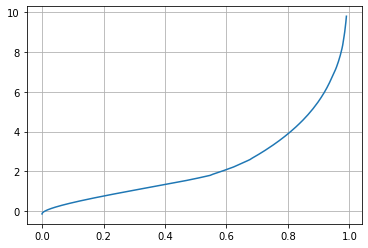

In [30]:
IW = np.vectorize(fO2_buffers_H22)
#plt.plot(1-ts('M_sys')/ts('M_sys')[0],ts('Fe3+_liquid')/(ts('FeO_liquid')+ts('Fe3+_liquid')))
#plt.twinx()
plt.plot(1-ts('M_sys')/ts('M_sys')[0],np.log10(ts('fO2'))-IW(ts('p_tot'),ts('T_pot')))
plt.grid()

In [29]:
print(ts('FeO_solid')+ts('Fe3+_solid'))

[0.05406712 0.05405841 0.05403959 0.05402401 0.05401147 0.05400089
 0.05399372 0.05398828 0.05398477 0.05398351 0.05398403 0.05398584
 0.0539899  0.05399588 0.054002   0.05401125 0.0540204  0.05403254
 0.05404436 0.05405856 0.05407439 0.0540909  0.05410805 0.0541274
 0.05414801 0.05416961 0.05419265 0.0542167  0.05424204 0.05426864
 0.05429633 0.05432557 0.05435589 0.05438766 0.05442075 0.05445508
 0.05448982 0.05452615 0.05456462 0.0546048  0.05464641 0.05468751
 0.05473051 0.05477698 0.0548248  0.05487089 0.05492107 0.05497431
 0.0550265  0.05508    0.05513923 0.0551963  0.05525549 0.05532125
 0.05538164 0.05544976 0.05552002 0.05558668 0.05566476 0.05573545
 0.05581624 0.05590968 0.05601517 0.05612636 0.05622809 0.05634326
 0.05644275 0.05655995 0.05665859 0.05677657 0.05687642 0.05699589
 0.05709508 0.05490795 0.05501438 0.05514379 0.05525175 0.05538324
 0.05549511 0.05562591 0.05574462 0.05587179 0.055011   0.05512711
 0.05526221 0.0553759  0.05551784 0.05563622 0.05577415 0.05401

In [26]:
# Brouillon
print('Parameters ================')
print('Temperature =',MO.adiabat.T_pot+273.15,'°C, Mass MO =',MO.M_system*1e3,'g, Mass Planet =',5.98e27,'g, Radius =', MO.R_out*1e-3,'km')
print('Target ===================')
print('logfO2-IW = ',np.log10(MO.averages['fO2_sfc'])-fO2_buffers_H22(MO.atm.ps,MO.adiabat.T_pot),',',
      'H2O tot = ',MO.content['system']['H']/H2O.coefs[H]/H.atomic_mass*H2O.molecular_mass*1e6,'ppm,',
      'C tot = ',MO.content['system']['C']*1e6,'ppm,',
      'N tot = ',MO.content['system']['N']*1e6,'ppm,',
      'Ar tot = ',0,'ppm',
      'S tot = ',0,'ppm')
print('Output ===================')
print('Atmosphere')
print('M am =',MO.atm.getMass(),'kg, '
      'p_tot=',MO.atm.ps*1e-5,'bar, '
      'N2 = ',MO.atm.partial_pressure['N2']/MO.atm.ps*N2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
      'H2O= ',MO.atm.partial_pressure['H2O']/MO.atm.ps*H2O.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
      'H2 = ',MO.atm.partial_pressure['H2']/MO.atm.ps*H2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
      'CO2= ',MO.atm.partial_pressure['CO2']/MO.atm.ps*CO2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
      'CO = ',MO.atm.partial_pressure['CO']/MO.atm.ps*CO.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
      'CH4 = ',MO.atm.partial_pressure['CH4']/MO.atm.ps*CH4.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
      'O2 = ',MO.averages['fO2_sfc']*1e5/MO.atm.ps*O2.molecular_mass/MO.atm.average_molecular_mass*100,'wt%, '
      'HCN = ',MO.atm.partial_pressure['HCN']/MO.atm.ps*HCN.molecular_mass/MO.atm.average_molecular_mass*100,'wt%'
      'NH3 = ',MO.atm.partial_pressure['NH3']/MO.atm.ps*NH3.molecular_mass/MO.atm.average_molecular_mass*100,'wt%')
print('Silicate melt')
print('H2O =',MO.content['liquid']['H2O']*1e6,'ppm, ',
      'H2=',MO.content['liquid']['H2']*1e6,'ppm, ',
      'CO2=',MO.content['liquid']['CO2']*1e6,'ppm, ',
      'CO=',MO.content['liquid']['CO']*1e6,'ppm, ',
      'CH4=',MO.content['liquid']['CH4']*1e6,'ppm, ',
      'S=',0,'ppm, ',
      'N=',MO.content['liquid']['N']*1e6,'ppm')

Parameters ================
Temperature = 1756.15 °C, Mass MO = 2.2177933851465757e+25 g, Mass Planet = 5.98e+27 g, Radius = 6371.0 km
Target ===================


KeyError: 'fO2_sfc'

In [ ]:
print(sum([MO.atm.getMass(sp.formula)*sp.coefs[H]*H.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass()))
print(sum([MO.atm.getMass(sp.formula)*sp.coefs[C]*C.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass()))
print(sum([MO.atm.getMass(sp.formula)*sp.coefs[N]*N.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass()))
print(sum([MO.atm.getMass(sp.formula)*sp.coefs[O]*O.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass()))

In [ ]:
# mass fraction
x_spec ={'H':sum([MO.atm.getMass(sp.formula)*sp.coefs[H]*H.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass()),
         'C':sum([MO.atm.getMass(sp.formula)*sp.coefs[C]*C.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass()),
         'N':sum([MO.atm.getMass(sp.formula)*sp.coefs[N]*N.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass()),
         'O':sum([MO.atm.getMass(sp.formula)*sp.coefs[O]*O.atomic_mass/sp.molecular_mass for sp in MO.atm.gases])/(MO.atm.getMass())}

x_M = {'H':x_spec['H']/H.atomic_mass,
       'C':x_spec['C']/C.atomic_mass,
       'N':x_spec['N']/N.atomic_mass,
       'O':x_spec['O']/O.atomic_mass}

# molar fraction
x_mol={'H':x_spec['H']/H.atomic_mass/sum([x_M[e] for e in x_M]),
       'C':x_spec['C']/C.atomic_mass/sum([x_M[e] for e in x_M]),
       'N':x_spec['N']/N.atomic_mass/sum([x_M[e] for e in x_M]),
       'O':x_spec['O']/O.atomic_mass/sum([x_M[e] for e in x_M])}

# FastChem abundance format
x_log={'H':12.,
       'C':np.log10(x_mol['C']/x_mol['H'])+12.,
       'N':np.log10(x_mol['N']/x_mol['H'])+12.,
       'O':np.log10(x_mol['O']/x_mol['H'])+12.}

print('xH=',x_log['H'],'xC=',x_log['C'],'xN=',x_log['N'],'xO=',x_log['O'])
print(list(x_log.keys()),list(x_log.values()))
#np.savetxt('/home/maxime/Projects/MO_atmosphere_coupling/Atmosphere_evol/fastchem_in.dat',[list(x_log.keys()),list(x_log.values())])

In [27]:
print(MO.atm.Ts,MO.atm.ps)

3003.0 15486638.640915278
